In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import numpy as np

from utils import tf_config

dataset="04"
memory_limit=1500
interval_eeg=10

tf_config.set_seed(seed=2)#02 [2, 3, 5, 7, 11]
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

import GPyOpt

import argparse

from utils import preprocess_data, search_algorithms, train, losses_utils, metrics, eeg_utils, data_utils

from models import fmri_ae, eeg_to_fmri, uniconv_fmri

from layers import locally_connected

import matplotlib.pyplot as plt



n_individuals=getattr(data_utils, "n_individuals_"+dataset)

with tf.device('/CPU:0'):
    train_data, test_data = preprocess_data.dataset(dataset, n_individuals=n_individuals,
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    eeg_train, fmri_train =train_data
    eeg_test, fmri_test = test_data

2022-06-28 08:57:29.779634: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-06-28 08:57:30.966969: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-28 08:57:30.967407: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-28 08:57:31.008094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 08:57:31.008515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-06-28 08:57:31.008531: I tensorflow/stream_executor/platform/def

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


In [3]:
from utils import viz_utils, bnn_utils
from scipy.ndimage import rotate
import copy
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

## Single display plot

In [ ]:





T = 10
xslice=14

cmap = copy.copy(mpl.cm.get_cmap(plt.cm.nipy_spectral))
cmap.set_over("w")

def normalize_img(img, threshold=0.37):
    img = (img[:,:,:,:]-np.amin(img[:,:,:,:]))/(np.amax(img[:,:,:,:])-np.amin(img[:,:,:,:]))
    img[np.where(img < threshold)]= 1.001
    
    return img
    

    
fig = plt.figure(figsize=(25,7))
gs = GridSpec(2, 9, figure=fig, wspace=0.01, hspace=0.05)#, wspace=-0.4)



for instance_x, instance_y in dev_set.repeat(1):
    
    
    ground_truth = instance_y.numpy()
    y_hat = bnn_utils.predict_MC(model, (instance_x, instance_y), T=T).numpy()
    epistemic = bnn_utils.epistemic_uncertainty(model, (instance_x, instance_y), T=T).numpy()
    aleatoric = model(instance_x, instance_y)[0][1].numpy()
    
    #ground_truth = normalize_img(ground_truth)
    #y_hat = normalize_img(y_hat)
    #epistemic = normalize_img(epistemic)
    #aleatoric = normalize_img(aleatoric)
    
    
    axes = fig.add_subplot(gs[:,0])
    axes.text(0.75,0.13,"DCTVariational", rotation="vertical", size=40)
    
    axes.axis("off")
    #ground truth
    axes = fig.add_subplot(gs[:,1:3])
    axes.imshow(rotate(ground_truth[0,:,:,xslice,0], 90, axes=(0,1)),
              cmap=cmap)
    axes.axis("off")
    #predicted view
    axes = fig.add_subplot(gs[:,3:5])
    axes.imshow(rotate(y_hat[0,:,:,xslice,0], 90, axes=(0,1)),
              cmap=cmap)
    axes.axis("off")
    #epistemic uncertainty
    axes = fig.add_subplot(gs[:,5:7])
    axes.imshow(rotate(epistemic[0,:,:,xslice,0], 90, axes=(0,1)),
              cmap=cmap)
    axes.axis("off")
    #aleatoric uncertainty
    axes = fig.add_subplot(gs[:,7:9])
    axes.imshow(rotate(aleatoric[0,:,:,xslice,0], 90, axes=(0,1)),
              cmap=cmap)
    axes.axis("off")
    
    plt.rcParams["font.family"] = "serif"
    plt.tight_layout()
    plt.show()
    
    break

## Whole brain display plot

In [ ]:
T = 10
factor=5
cmap = copy.copy(mpl.cm.get_cmap(plt.cm.nipy_spectral))
cmap.set_over("w")

    
fig = plt.figure(figsize=(22,30))
gs = GridSpec(ground_truth.shape[3]//factor, 9, figure=fig, wspace=0.01, hspace=0.05)#, wspace=-0.4)

for instance_x, instance_y in dev_set.repeat(1):
    
    
    ground_truth = instance_y.numpy()
    y_hat = bnn_utils.predict_MC(model, (instance_x, instance_y), T=T).numpy()
    epistemic = bnn_utils.epistemic_uncertainty(model, (instance_x, instance_y), T=T).numpy()
    aleatoric = model(instance_x, instance_y)[0][1].numpy()
    
    for xslice in reversed(range(factor,ground_truth.shape[3],factor)):
        
        axes = fig.add_subplot(gs[(ground_truth.shape[3]-xslice)//factor-1,0])
        if(xslice==factor):
            x_shift=0.2
        else:
            x_shift=0.15
        axes.text(0.75,x_shift, "slice "+str(xslice)+"/"+str(ground_truth.shape[3]), size=35, rotation="vertical")
        axes.axis("off")
        #ground truth
        axes = fig.add_subplot(gs[(ground_truth.shape[3]-xslice)//factor-1,1:3])
        axes.imshow(rotate(ground_truth[0,:,:,xslice,0], 90, axes=(0,1)),
                  cmap=cmap)
        if(xslice==ground_truth.shape[3]-factor):
            axes.set_title("Ground Truth", size=35)
        axes.axis("off")
        #predicted view
        axes = fig.add_subplot(gs[(ground_truth.shape[3]-xslice)//factor-1,3:5])
        axes.imshow(rotate(y_hat[0,:,:,xslice,0], 90, axes=(0,1)),
                  cmap=cmap)
        if(xslice==ground_truth.shape[3]-factor):
            axes.set_title("Predicted", size=35)
        axes.axis("off")
        #epistemic uncertainty
        axes = fig.add_subplot(gs[(ground_truth.shape[3]-xslice)//factor-1,5:7])
        axes.imshow(rotate(epistemic[0,:,:,xslice,0], 90, axes=(0,1)),
                  cmap=cmap)
        if(xslice==ground_truth.shape[3]-factor):
            axes.set_title("Epistemic", size=35)
        axes.axis("off")
        #aleatoric uncertainty
        axes = fig.add_subplot(gs[(ground_truth.shape[3]-xslice)//factor-1,7:9])
        axes.imshow(rotate(aleatoric[0,:,:,xslice,0], 90, axes=(0,1)),
                  cmap=cmap)
        if(xslice==ground_truth.shape[3]-factor):
            axes.set_title("Aleatoric", size=35)
        axes.axis("off")

    plt.rcParams["font.family"] = "serif"
    plt.tight_layout()
    plt.show()
    
    break

## Plot to evaluate the influence of $H$

In [3]:
H=[2,5,7,10,13,15,18,20]

sinusoids_res = np.zeros((8,64,64,30,1))
path_res = "/home/ist_davidcalhas/eeg_to_fmri/metrics/01_topographical_attention_random_fourier_features_attention_style_variational_VonMises_dependent_h_"

for sin in range(len(H)):
    sinusoids_res[sin] = np.mean(np.squeeze(np.load(path_res+str(H[sin])+"_30x30x15_res_2.0/metrics/res_seed_11.npy"), axis=1), axis=0)

In [4]:
R=["3x3x1","6x6x3","12x12x6","15x15x7","18x18x9","20x20x10","25x25x12","32x32x15"]

resolutions_res = np.zeros((8,64,64,30,1))
path_res = "/home/ist_davidcalhas/eeg_to_fmri/metrics/01_topographical_attention_random_fourier_features_attention_style_variational_VonMises_dependent_h_15_"

for res in range(len(R)):
    resolutions_res[res] = np.mean(np.squeeze(np.load(path_res+R[res]+"_res_2.0/metrics/res_seed_11.npy"), axis=1), axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

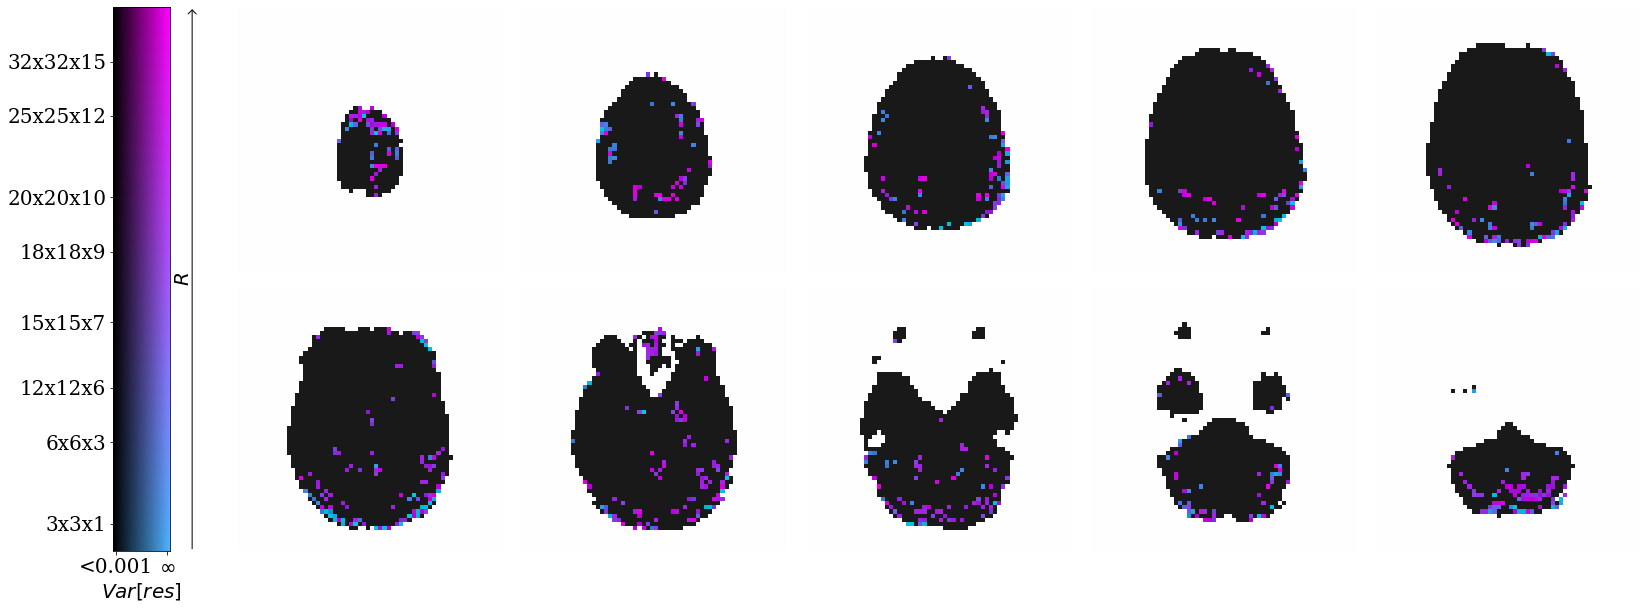

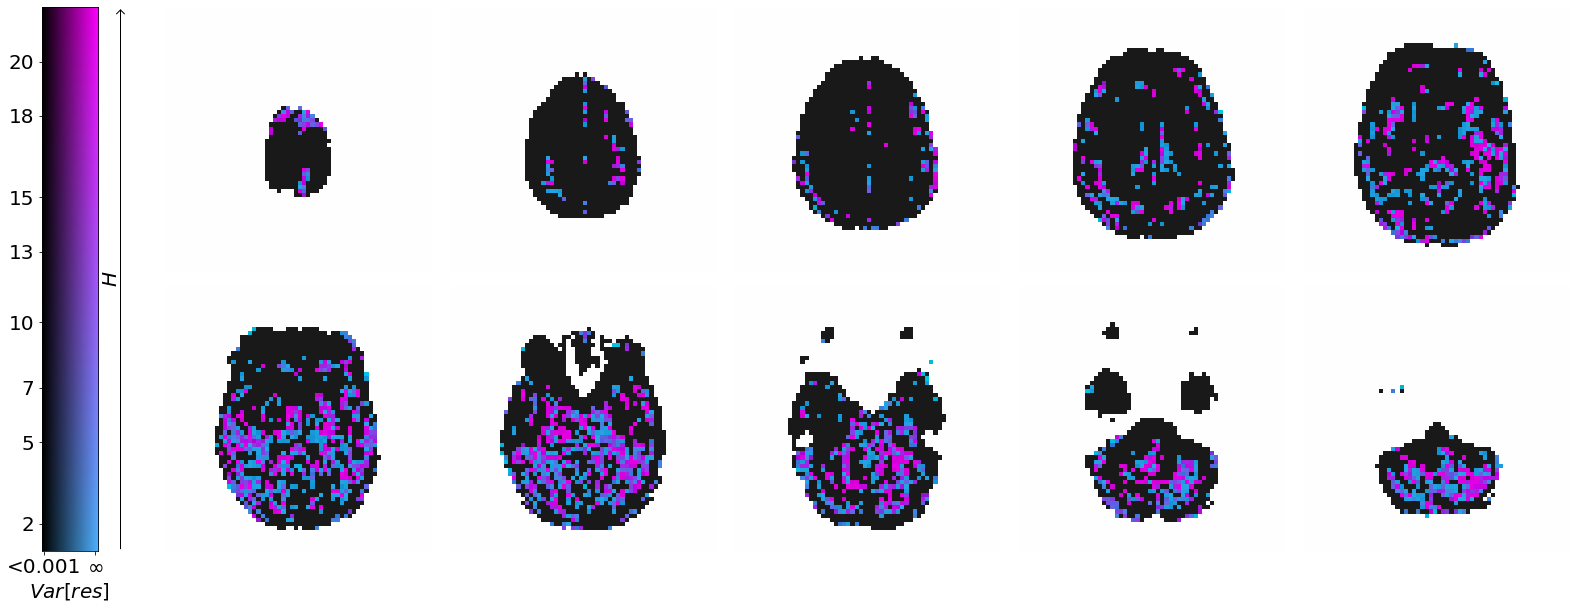

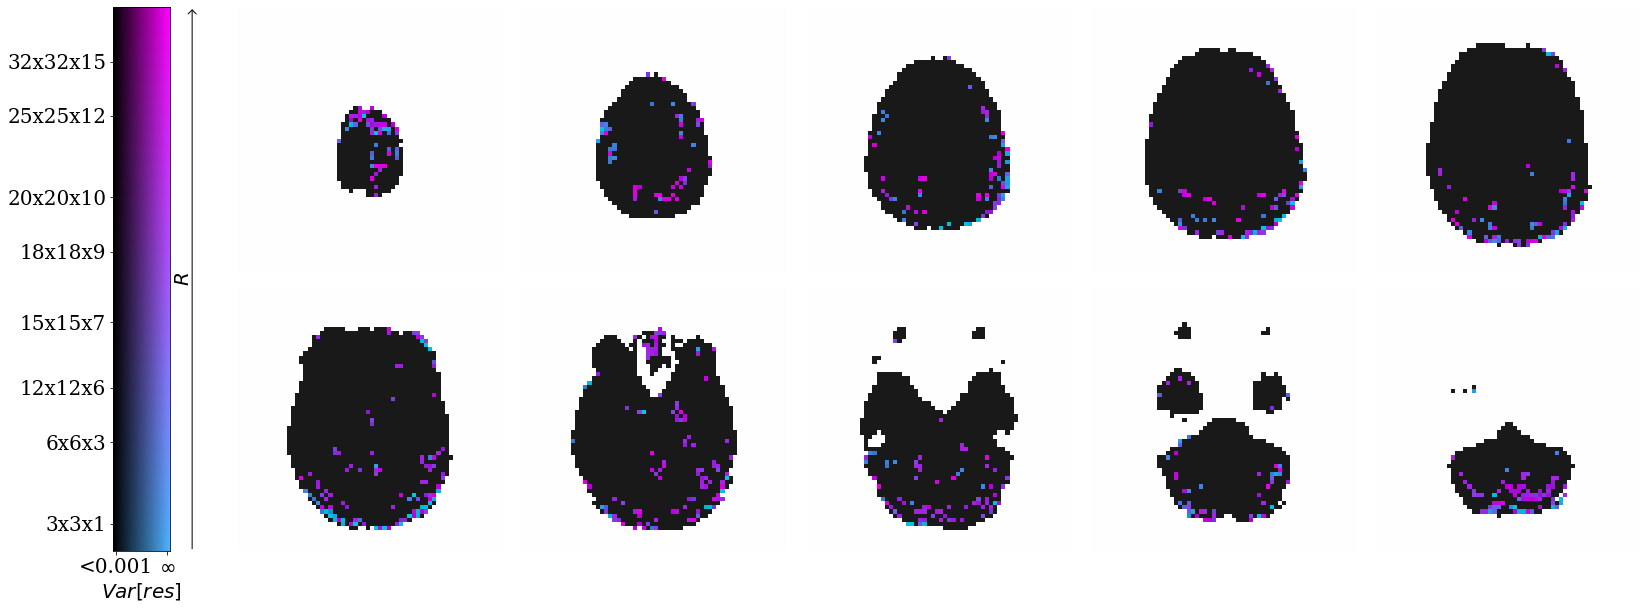

In [5]:
viz_utils.plot_analysis_uncertainty(sinusoids_res, fmri_train, H, xlabel=r"$Var[res]$", ylabel=r"$H$", threshold=0.37, save=True, save_path="sinusoids.pdf", save_format="pdf")
viz_utils.plot_analysis_uncertainty(resolutions_res, fmri_train, R, xlabel=r"$Var[res]$", ylabel=r"$R$", threshold=0.37, save=True, save_path="resolutions.pdf", save_format="pdf")

In [15]:
padded="01_topographical_attention_random_fourier_features_attention_style_padded_Normal_res_2.0"
stochastic="01_topographical_attention_random_fourier_features_attention_style_variational_VonMises_dependent_h_5_32x32x15_res_2.0"


path_res="/home/ist_davidcalhas/eeg_to_fmri/metrics/"

seeds=[2,3,5,7,11]

padded_res=np.zeros((5,64,64,30,1))
stochastic_res=np.zeros((5,64,64,30,1))

for mode in ["padded", "stochastic"]:
    
    for seed in range(len(seeds)):

        

        globals()[mode+"_res"][seed]=np.mean(np.load(path_res+globals()[mode]+"/metrics/res_seed_"+str(seeds[seed])+".npy"), axis=0)

    

In [16]:
stochastic_res.shape

(5, 64, 64, 30, 1)

In [17]:
padded_res.shape

(5, 64, 64, 30, 1)

In [18]:
from scipy.stats import ttest_ind

In [19]:
pvalues=ttest_ind(stochastic_res, padded_res, axis=0).pvalue

In [20]:
np.sum((pvalues<0.05).astype("int32"))

7410

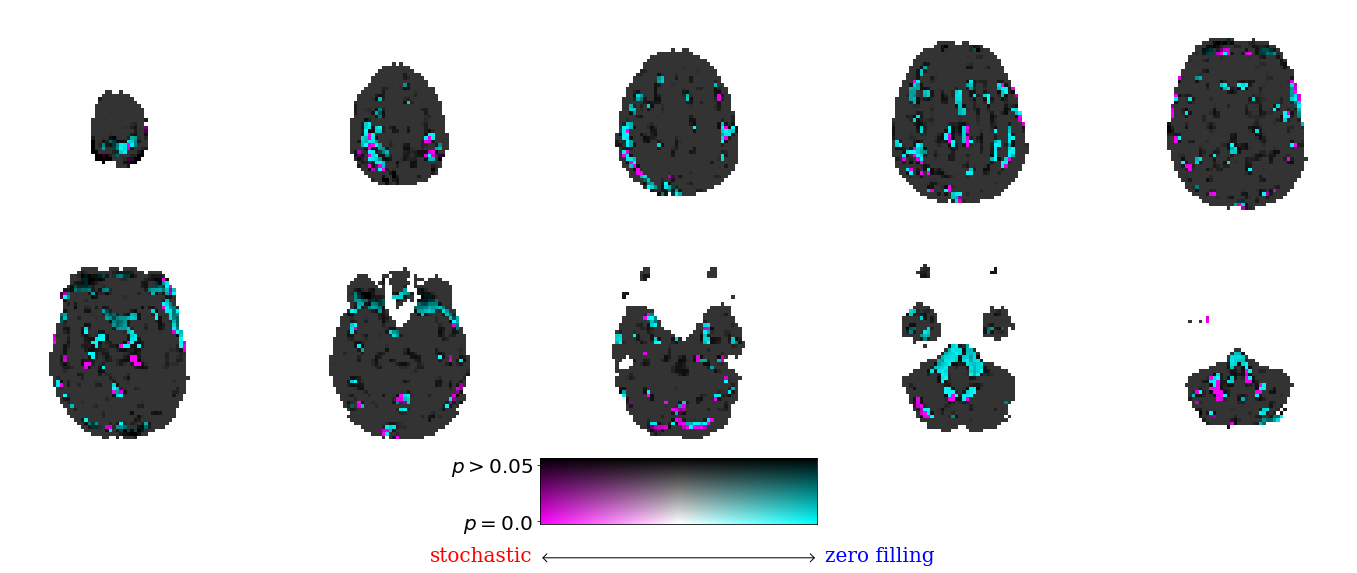

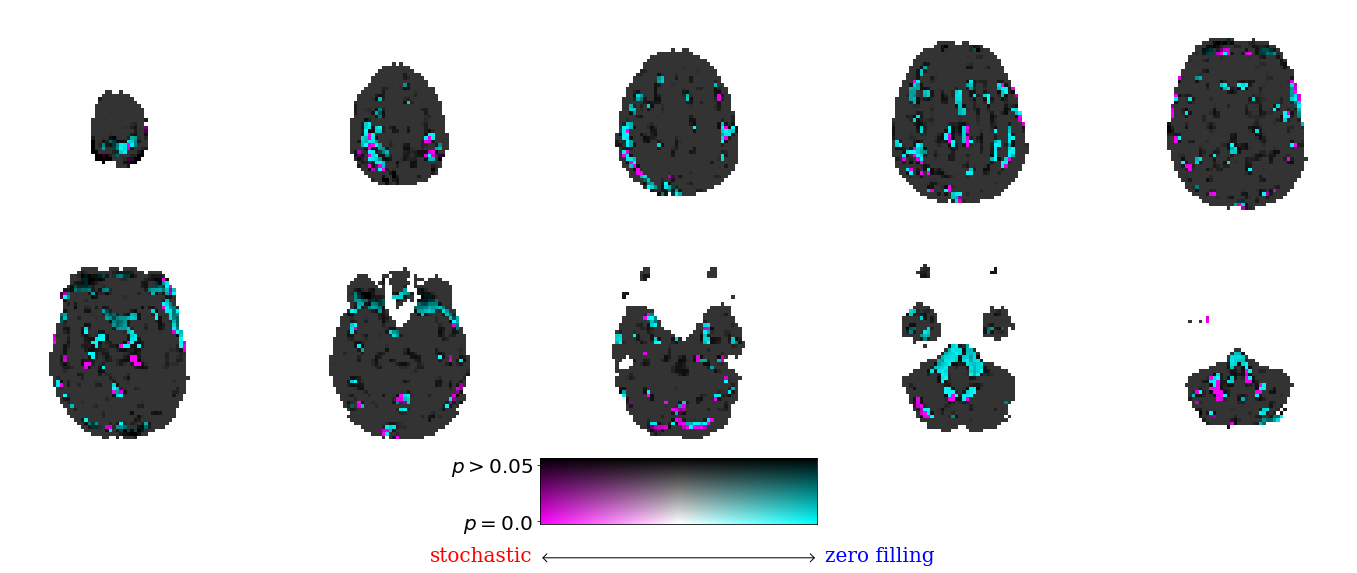

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

def comparison_plot_uncertainty(res1, res2, pvalues, res_img, model1="Model1", model2="Model2", factor=3, h_resolution=1, v_resolution=1, threshold=0.37, slice_label=True, save=False, save_path=None, red_blue=False, save_format="pdf"):
    """
        
    Inputs:
        res1: Numpy.ndarray - of shape (X,Y,Z,1)
        res2: Numpy.ndarray - of shape (X,Y,Z,1)
        pvalues: Numpy.ndarray - of shape (X,Y,Z,1)
        res_img: Numpy.ndarray - of shape (X,Y,Z,1)
        factor: float - that resamples the Z axis slices
        h_resolution: int - resolution in the horizontal dimension
        v_resolution: int - resolution in the vertical dimension
        save: bool - whether to save the figure
        save_path: str - path to save the figure, save has to be True
    Returns:
        matplotlib.Figure - The figure to plot, no saving option implemented
    """
    label = "$Z_{"

    #colormap definition
    if(red_blue):
        cp1 = np.linspace(0,1)
        cp2 = np.linspace(0,1)
        Cp1, Cp2 = np.meshgrid(cp1,cp2)
        C0 = np.full_like(Cp1, Cp1*Cp2*((Cp1)+(Cp2))/2)
        p_values_range=Cp2#place holder that can stay to emulate pvalues
        Legend = np.dstack((np.concatenate((Cp2, p_values_range*Cp1[:,::-1], ), axis=1)[:,::-1],
                            np.concatenate((C0,C0[:,::-1]), axis=1),
                            np.concatenate((p_values_range*Cp1, Cp2), axis=1)[:,::-1]))
        cmap=ListedColormap(Legend)
    else:
        cp1 = np.linspace(0,1)
        cp2 = np.linspace(0,1)
        Cp1, Cp2 = np.meshgrid(cp1,cp2)
        C0 = np.full_like(Cp1, Cp1*Cp2*((Cp1)+(Cp2))/2)
        Cp2_ = np.triu(Cp2)
        np.fill_diagonal(Cp2_, 0)
        p_values_range=Cp2#place holder that can stay to emulate pvalues
        Legend = np.dstack((np.concatenate((p_values_range*Cp1, Cp2), axis=1)[:,::-1],
                            np.concatenate((Cp2, p_values_range*Cp1[:,::-1], ), axis=1)[:,::-1],
                            np.concatenate((Cp2, Cp2), axis=1)[:,::-1]))
        cmap=ListedColormap(Legend)

    #normalization
    res_img = (res_img[:,:,:,:]-np.amin(res_img[:,:,:,:]))/(np.amax(res_img[:,:,:,:])-np.amin(res_img[:,:,:,:]))
    res_img[np.where(res_img < threshold)]= -1


    #assign colors
    instance =np.zeros(res1[:,:,:,0].shape+(3,))
    res1=np.abs(res1)+1e-9
    res2=np.abs(res2)+1e-9
    res1[np.where(res1>1.0)]=0.9999#1.0
    res2[np.where(res2>1.0)]=0.9999#1.0

    def _cmap_(res1, res2, voxel, pvalue=0.0, red_blue=False):
        if(voxel==-1):
            return (0.999,0.999,0.999)
        elif(pvalue>0.05):
            pvalue=np.clip(pvalue, a_min=1e-9, a_max=0.2)
            return (pvalue,pvalue,pvalue)
        if(red_blue):
            if(res1<res2):
                return (1+1e-30-res1, 0.0001, pvalue+1e-9)
            return (pvalue+1e-9, 0.0001, 1+1e-30-res2)
        else:
            if(res1<res2):
                return (0.0001, 1+1e-30-res1, 1+1e-30-res1)
            return (1+1e-30-res2, 0.0001, 1+1e-30-res2)

    for voxel1 in range(instance.shape[0]):
        for voxel2 in range(instance.shape[1]):
            for voxel3 in range(instance.shape[2]):
                instance[voxel1,voxel2,voxel3] = np.array(list(_cmap_(res1[voxel1,voxel2,voxel3,0], res2[voxel1,voxel2,voxel3,0], 
                                                                res_img[voxel1,voxel2,voxel3,0],
                                                                pvalue=pvalues[voxel1,voxel2,voxel3,0],
                                                                red_blue=red_blue)))

    fig = plt.figure(figsize=(25,17))
    gs = GridSpec(41, 5, figure=fig, wspace=0.01, hspace=0.05)#, wspace=-0.4)

    #colorbar
    cax = fig.add_subplot(gs[30:33,2:3])
    cax.imshow(Legend, extent=[0,100,0,100], aspect="auto")
    cax.set_xticks([])
    cax.set_yticks([5,90])
    cax.annotate('', xy=(0, -0.5), xycoords='axes fraction', xytext=(1, -0.5), 
                arrowprops=dict(arrowstyle="<->, head_width=0.4", color='black'))
    cax.annotate(model1, xy=(0, -0.56), xycoords='axes fraction', xytext=(-0.4, -0.56), size=20, color="red")
    cax.annotate(model2, xy=(0, -0.56), xycoords='axes fraction', xytext=(1.03, -0.56), size=20, color="blue")
    cax.set_yticklabels([r"$p=0.0$",r"$p>0.05$"], size=20)
    

    #plot each slice in 2 Dimensional plot
    row = 1
    col = 4
    for axis in range((instance[:,:,:].shape[2])//factor):
        if(row==1):
            _row=20
        else:
            _row=10
        axes = fig.add_subplot(gs[_row:_row+10,col])
        img = rotate(instance[:,:,axis*factor,:], 90)
        axes.imshow(img)
        if(slice_label):
            axes.text(28, 3, label+str(axis*factor)+"}$", size=13,
                 va="baseline", ha="left", multialignment="left",)
        axes.axis("off")
        col -= 1
        if(col == -1):
            col=4
            row-=1

    plt.rcParams["font.family"] = "serif"
    fig.set_tight_layout(True)

    if(save):
        fig.savefig(save_path, format=save_format)

    return fig


comparison_plot_uncertainty(np.mean(stochastic_res, axis=0), 
                            np.mean(padded_res, axis=0), 
                            pvalues, np.mean(fmri_train, axis=0),
                           model1="stochastic",
                           model2="zero filling",
                            slice_label=False,
                           save=True,
                           save_path="padded_vs_stochastic_calhas.pdf")

In [32]:
pvalues.shape

(64, 64, 30, 1)

In [34]:
stochastic_res.shape

(5, 64, 64, 30, 1)

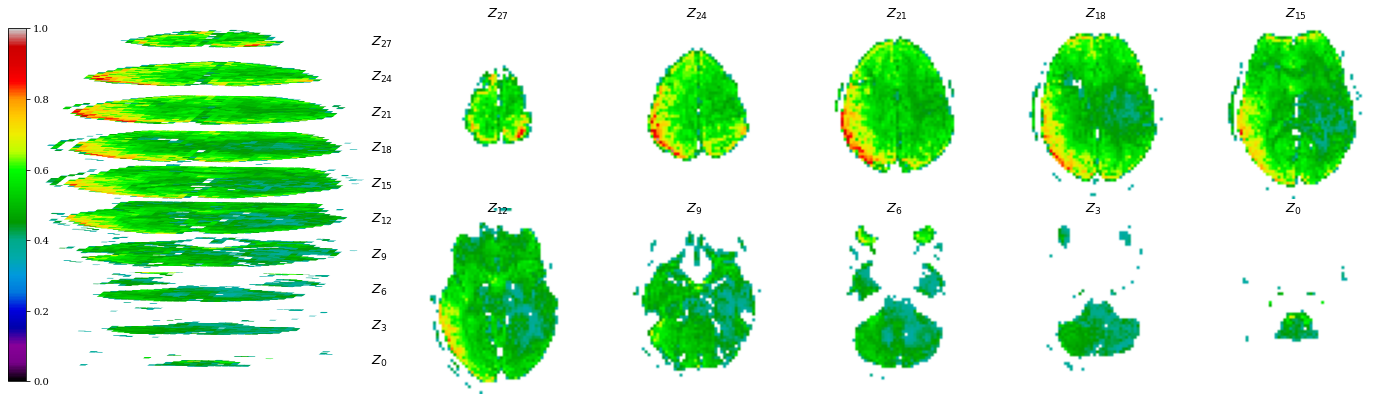

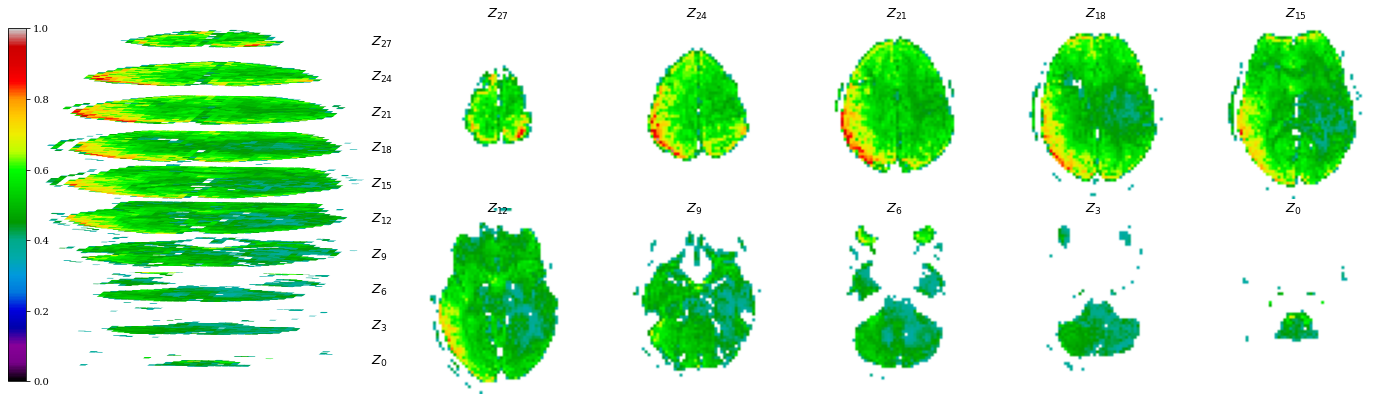

In [15]:
viz_utils.plot_3D_representation_projected_slices(fmri_train[0,:,:,:,:], threshold=0.37)